### Import libraries

In [1]:
#install required libraries
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.combine import SMOTETomek

from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, confusion_matrix, fbeta_score, precision_score, \
                            recall_score, roc_auc_score, classification_report, f1_score, roc_curve
                            
from sklearn.base import TransformerMixin

from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, GridSearchCV
from sklearn.feature_selection import RFECV

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings

pd.set_option('display.max_rows', None)
warnings.filterwarnings("ignore")
%matplotlib inline

### Load and split data into train and test sets

In [2]:
#Read Data
#load downloaded file
INPUT_PATH = r"C:\Users\User\Desktop\portfolio\cc_defaulter_prediction\artifacts\data_ingestion\CreditCardClients.xls"
df = pd.read_excel(INPUT_PATH, header=1)
#drop id colum
df.drop(columns='ID', inplace=True)
#rename columns for convenience
df.rename(columns = {'PAY_0': 'PAY_1', 'default payment next month': 'Default'}, inplace=True)

#lowering column names 
df.columns = [col.lower() for col in df.columns]
#split the data based on class label
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=33)
# Use the split method to get the indices for training and testing
strat_train_set = None
strat_test_set = None
for train_idx, test_idx in split.split(df, df.iloc[:,-1]):
    df_train = df.loc[train_idx]
    df_test = df.loc[test_idx]
            

### Model Building

Train model with all the features<br>
    - With Dummy classifier <br>
    - With engineered features <br>
    - Recursive Feature Engineering with Cross Validation <br>
    - Model interpretability <br>

In [3]:
#helper functions
def evaluate_clf(true, predicted):
    '''
    Input: True values and Predicted values
    Returns: Accuracy, F1-Score, Precision, Recall, Roc-auc Score
    '''
    acc = accuracy_score(true, predicted) # Calculate Accuracy
    f1 = f1_score(true, predicted) # Calculate F1-score
    precision = precision_score(true, predicted) # Calculate Precision
    recall = recall_score(true, predicted)  # Calculate Recall
    roc_auc = roc_auc_score(true, predicted) #Calculate Roc
    return acc, f1 , precision, recall, roc_auc

In [4]:
#print confusion matrix and classification report
def display_confusion_matrix(y_true, y_pred, labels):
    '''
    This function takes y_ture, y_predicted, class labels and returns false positives and false negatives
   
    '''
    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=labels)#, normalize='all')
    print("Confusion Matrix: \n", cm)
    print("Classification Report: \n", classification_report(y_true, y_pred, labels=labels))

In [5]:
# Create a function which can evaluate models and return a report 

def evaluate_models(X_train, y_train, x_test, y_test, models):
    '''
    This function takes in X and y and models dictionary as input
   
    Iterates through the given model dictionary and evaluates the metrics
    Returns: Dataframe which contains report of all models metrics with cost
    '''
   
    #list of measures that goes into report dataframe
    models_list = []
    model_train_accuracy_list = []
    train_f1 = []
    test_f1 = []
    model_test_accuracy_list = []
    train_roc_auc = []
    test_roc_auc =[]
    train_precision =[]
    test_precision=[]
    train_recall=[]
    test_recall=[]
    f2_score = []
    
    for i in range(len(list(models))):
        model = list(models.values())[i]
        model.fit(X_train, y_train) # Train model

        # Make predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(x_test)

        # Training set performance
        model_train_accuracy, model_train_f1,model_train_precision,\
        model_train_recall,model_train_rocauc_score=evaluate_clf(y_train ,y_train_pred)


        # Test set performance
        model_test_accuracy,model_test_f1,model_test_precision,\
        model_test_recall,model_test_rocauc_score=evaluate_clf(y_test, y_test_pred)
        
        print(list(models.keys())[i])
        models_list.append(list(models.keys())[i])
        model_train_accuracy_list.append(model_train_accuracy)
        model_test_accuracy_list.append(model_test_accuracy)
        train_f1.append(model_train_f1)
        test_f1.append(model_test_f1)
        train_roc_auc.append(model_train_rocauc_score)
        test_roc_auc.append(model_test_rocauc_score)
        train_precision.append(model_train_precision)
        test_precision.append(model_test_precision)
        train_recall.append(model_train_recall)
        test_recall.append(model_test_recall)
        f2_score.append(fbeta_score(y_test, y_test_pred, beta=2))

        print('Model performance for Training set')
        print("- Accuracy: {:.4f}".format(model_train_accuracy))
        print('- F1 score: {:.4f}'.format(model_train_f1)) 
        print('- Precision: {:.4f}'.format(model_train_precision))
        print('- Recall: {:.4f}'.format(model_train_recall))
        print('- Roc Auc Score: {:.4f}'.format(model_train_rocauc_score))
        display_confusion_matrix(y_train, y_train_pred, model.classes_)


        print('----------------------------------')

        print('Model performance for Test set')
        print('- Accuracy: {:.4f}'.format(model_test_accuracy))
        print('- F1 score: {:.4f}'.format(model_test_f1))
        print('- Precision: {:.4f}'.format(model_test_precision))
        print('- Recall: {:.4f}'.format(model_test_recall))
        print('- Roc Auc Score: {:.4f}'.format(model_test_rocauc_score))
        display_confusion_matrix(y_test, y_test_pred, model.classes_)

        
        print('='*35)
        print('\n')
        
    report_data = {
        'Model Name': models_list,
        'Train Accuracy': model_train_accuracy_list,
        'Test Accuracy': model_test_accuracy_list,
        'Train_F1': train_f1,
        'Test_F1': test_f1,
        'Test_ROC_AUC_score': test_roc_auc,
        'Train_ROC_AUC_score': train_roc_auc,
        'Train_presicion': train_precision,
        'Test_precision': test_precision,
        'Train_recall': train_recall,
        'Test_recall': test_recall,
        'F2-Score': f2_score
    }
    
    report = pd.DataFrame(report_data).sort_values(by=['Test_ROC_AUC_score','F2-Score', 'Test_F1'], ascending=False)        
    return report

In [6]:

#list of classification models
models = {
    "Baseline Classifier": DummyClassifier(strategy='most_frequent'),
    "Logistic Regression": LogisticRegression(),#(class_weight='balanced'),
    "SVM": SVC(),#(class_weight='balanced'),
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(),#(class_weight='balanced'),
    "Random Forest": RandomForestClassifier(),#(class_weight='balanced'),
    "Gradient Boost": GradientBoostingClassifier(),
    "Adaboost": AdaBoostClassifier(),
    "Extra tree": ExtraTreesClassifier(),#(class_weight='balanced'),
    "XGBoost": XGBClassifier()
}

In [7]:
def preprocess(numeric_features, categorical_features):#, model_name, model):
    '''
    input: list of numerical features and categorical features
    applies transformers on given data
    returns: preprocessed object
    '''
    
    # Create transformers
    categorical_transformer = OneHotEncoder()
    #feature_generator = FeatureGenerator()
    
    # Create transformers
    numeric_transformer = Pipeline(steps=[('scaler', RobustScaler())])

    categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

        # Create a column transformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    # Create the pipeline
    pipeline = Pipeline(steps=[('preprocessor', preprocessor)])
    
    return pipeline

In [8]:
categorical_features = ['sex', 'education', 'marriage','pay_1', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']
numeric_cols = ['age','limit_bal', 'bill_amt1', 'bill_amt2', 'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6', \
                 'pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6']

In [9]:
X_train = df_train.drop('default', axis=1)
y_train = df_train['default']

x_test=df_test.drop('default', axis=1)
y_test=df_test['default']
num_cols = numeric_cols#+engineered_cols
pipeline = preprocess(num_cols, categorical_features)
X_train_transformed = pipeline.fit_transform(X_train)
x_test_transformed = pipeline.transform(x_test)
column_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
X_train_transformed_df = pd.DataFrame(X_train_transformed.toarray(), columns = column_names)
x_test_transformed_df = pd.DataFrame(x_test_transformed.toarray(), columns = column_names)

In [10]:
report1 = evaluate_models(X_train=X_train_transformed_df, y_train=y_train, x_test=x_test_transformed_df, y_test=y_test, models=models)
report1  

Baseline Classifier
Model performance for Training set
- Accuracy: 0.7788
- F1 score: 0.0000
- Precision: 0.0000
- Recall: 0.0000
- Roc Auc Score: 0.5000
Confusion Matrix: 
 [[18691     0]
 [ 5309     0]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.78      1.00      0.88     18691
           1       0.00      0.00      0.00      5309

    accuracy                           0.78     24000
   macro avg       0.39      0.50      0.44     24000
weighted avg       0.61      0.78      0.68     24000

----------------------------------
Model performance for Test set
- Accuracy: 0.7788
- F1 score: 0.0000
- Precision: 0.0000
- Recall: 0.0000
- Roc Auc Score: 0.5000
Confusion Matrix: 
 [[4673    0]
 [1327    0]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.78      1.00      0.88      4673
           1       0.00      0.00      0.00      1327

    accuracy                           0.7

Extra tree
Model performance for Training set
- Accuracy: 0.9995
- F1 score: 0.9989
- Precision: 1.0000
- Recall: 0.9977
- Roc Auc Score: 0.9989
Confusion Matrix: 
 [[18691     0]
 [   12  5297]]
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     18691
           1       1.00      1.00      1.00      5309

    accuracy                           1.00     24000
   macro avg       1.00      1.00      1.00     24000
weighted avg       1.00      1.00      1.00     24000

----------------------------------
Model performance for Test set
- Accuracy: 0.8115
- F1 score: 0.4795
- Precision: 0.6158
- Recall: 0.3926
- Roc Auc Score: 0.6615
Confusion Matrix: 
 [[4348  325]
 [ 806  521]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.84      0.93      0.88      4673
           1       0.62      0.39      0.48      1327

    accuracy                           0.81      60

,Model Name,Train Accuracy,Test Accuracy,Train_F1,Test_F1,Test_ROC_AUC_score,Train_ROC_AUC_score,Train_presicion,Test_precision,Train_recall,Test_recall,F2-Score
8,Extra tree,0.999500,0.811500,0.998869,0.479521,0.661533,0.998870,1.000000,0.615839,0.997740,0.392615,0.423302
9,XGBoost,0.885917,0.819000,0.683028,0.477885,0.659873,0.767692,0.886152,0.660027,0.555660,0.374529,0.409998
5,Random Forest,0.999500,0.821500,0.998869,0.477816,0.659590,0.999072,0.999434,0.676796,0.998305,0.369254,0.406167
6,Gradient Boost,0.826042,0.824167,0.484122,0.477464,0.659143,0.662429,0.703664,0.696532,0.368996,0.363225,0.401667
1,Logistic Regression,0.820458,0.823667,0.466378,0.475719,0.658283,0.653719,0.680766,0.694645,0.354681,0.361718,0.400067
7,Adaboost,0.817917,0.820167,0.445994,0.453671,0.647402,0.643726,0.682047,0.691358,0.331324,0.337604,0.376091
2,SVM,0.818458,0.820000,0.429637,0.431579,0.637043,0.636118,0.704292,0.715532,0.309098,0.308968,0.348580
4,Decision Tree,0.999500,0.723667,0.998869,0.402307,0.615128,0.998870,1.000000,0.385625,0.997740,0.420497,0.413027
3,Naive Bayes,0.803792,0.805000,0.336293,0.344905,0.599895,0.596493,0.667973,0.671024,0.224713,0.232102,0.267037
0,Baseline Classifier,0.778792,0.778833,0.000000,0.000000,0.500000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000


#### Feature Engineering:

In [11]:
class FeatureGenerator(TransformerMixin):
    
    '''
    Upon calling fit_transform or transform method this column generates new dataframe columns
    '''
    def __init__(self):
      
        try:
            self.bill_amt1_ix = "bill_amt1"
            self.bill_amt2_ix = "bill_amt2"
            self.bill_amt3_ix = "bill_amt3"
            self.bill_amt4_ix = "bill_amt4"
            self.bill_amt5_ix = "bill_amt5"
            self.bill_amt6_ix = "bill_amt6"
            self.limit_bal_ix = "limit_bal"
            self.pay_amt1_ix = "pay_amt1"
            self.pay_amt2_ix = "pay_amt2"
            self.pay_amt3_ix = "pay_amt3"
            self.pay_amt4_ix = "pay_amt4"
            self.pay_amt5_ix = "pay_amt5"
            self.pay_amt6_ix = "pay_amt6"
            

        except Exception as e:
            print(e)


    def fit(self, X):
        return self

    def transform(self, X):
        '''
            X['leverage_1'] = X[self.bill_amt1_ix]/X[self.limit_bal_ix]   
            X['leverage_2'] = X[self.bill_amt2_ix]/X[self.limit_bal_ix]
            X['leverage_3'] = X[self.bill_amt3_ix]/X[self.limit_bal_ix]
            X['leverage_4'] = X[self.bill_amt4_ix]/X[self.limit_bal_ix]
            X['leverage_5'] = X[self.bill_amt5_ix]/X[self.limit_bal_ix]
            X['leverage_6'] = X[self.bill_amt6_ix]/X[self.limit_bal_ix]

            X['bill_to_pay1'] = X[self.bill_amt1_ix]/(X[self.pay_amt1_ix]+1)   
            X['bill_to_pay2'] = X[self.bill_amt2_ix]/(X[self.pay_amt2_ix]+1)
            X['bill_to_pay3'] = X[self.bill_amt3_ix]/(X[self.pay_amt3_ix]+1)
            X['bill_to_pay4'] = X[self.bill_amt4_ix]/(X[self.pay_amt4_ix]+1)
            X['bill_to_pay5'] = X[self.bill_amt5_ix]/(X[self.pay_amt5_ix]+1)
            X['bill_to_pay6'] = X[self.bill_amt6_ix]/(X[self.pay_amt6_ix]+1)
            
            X['overdraft'] = np.where(   (X[self.bill_amt1_ix]>X[self.limit_bal_ix]) |
                                        (X[self.bill_amt2_ix]>X[self.limit_bal_ix]) |
                                        (X[self.bill_amt3_ix]>X[self.limit_bal_ix]) |
                                        (X[self.bill_amt4_ix]>X[self.limit_bal_ix]) |
                                        (X[self.bill_amt5_ix]>X[self.limit_bal_ix]) |
                                        (X[self.bill_amt6_ix]>X[self.limit_bal_ix]),
                                        1, 0                                 
                                    )
        '''
        X['avg_bill_amt'] = (X[self.bill_amt1_ix]+X[self.bill_amt2_ix]+X[self.bill_amt3_ix] \
                                     +X[self.bill_amt4_ix]+X[self.bill_amt5_ix]+X[self.bill_amt6_ix])/6
        X['avg_leverage_ratio'] = (X[self.bill_amt1_ix]+X[self.bill_amt2_ix]+X[self.bill_amt3_ix] \
                                       +X[self.bill_amt4_ix]+X[self.bill_amt5_ix]+X[self.bill_amt6_ix])/(6*X[self.limit_bal_ix])
        X['avg_pay_amt'] = (X[self.pay_amt1_ix]+X[self.pay_amt2_ix]+X[self.pay_amt3_ix] \
                                      +X[self.pay_amt4_ix]+X[self.pay_amt5_ix]+X[self.pay_amt6_ix])/6
        X['avg_bill_to_pay'] = (X[self.bill_amt1_ix]+X[self.bill_amt2_ix]+X[self.bill_amt3_ix] \
                                       +X[self.bill_amt4_ix]+X[self.bill_amt5_ix]+X[self.bill_amt6_ix])/ \
                                        ((X[self.pay_amt1_ix]+X[self.pay_amt2_ix]+X[self.pay_amt3_ix] \
                                       +X[self.pay_amt4_ix]+X[self.pay_amt5_ix]+X[self.pay_amt6_ix])+1)

        return X


In [12]:

def preprocess1(numeric_features, categorical_features):#, model_name, model):
    '''
    input: list of numerical features and categorical features
    applies transformers on given data
    returns: preprocessed object
    '''
    
    # Create transformers
    categorical_transformer = OneHotEncoder()
    feature_generator = FeatureGenerator()
    
    # Create transformers
    numeric_transformer = Pipeline(steps=[('scaler', RobustScaler())])

    categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

        # Create a column transformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    # Create the pipeline
    pipeline = Pipeline(steps=[('feature generator', feature_generator),('preprocessor', preprocessor)])
    
    return pipeline

In [13]:
categorical_features = ['sex', 'education', 'marriage','pay_1', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']
numeric_cols = ['age','limit_bal', 'bill_amt1', 'bill_amt2', 'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6', \
                 'pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6']
engineered_cols = ['avg_bill_amt', 'avg_leverage_ratio', 'avg_pay_amt', 'avg_bill_to_pay']


In [14]:
X_train = df_train.drop('default', axis=1)
y_train = df_train['default']

x_test=df_test.drop('default', axis=1)
y_test=df_test['default']
num_cols = numeric_cols+engineered_cols
pipeline = preprocess1(num_cols, categorical_features)
X_train_transformed = pipeline.fit_transform(X_train)
x_test_transformed = pipeline.transform(x_test)
column_names = pipeline[1:].named_steps['preprocessor'].get_feature_names_out()
X_train_transformed_df = pd.DataFrame(X_train_transformed.toarray(), columns = column_names)
x_test_transformed_df = pd.DataFrame(x_test_transformed.toarray(), columns = column_names)

In [15]:
#type(pipeline[:-1].named_steps['preprocessor']).get_feature_names_out(numeric_cols)
#pipeline.named_steps['preprocessor'].named_transformers_
len(pipeline[1:].named_steps['preprocessor'].get_feature_names_out())

95

In [16]:
report2 = evaluate_models(X_train=X_train_transformed_df, y_train=y_train, x_test=x_test_transformed_df, y_test=y_test, models=models)
report2  

Baseline Classifier
Model performance for Training set
- Accuracy: 0.7788
- F1 score: 0.0000
- Precision: 0.0000
- Recall: 0.0000
- Roc Auc Score: 0.5000
Confusion Matrix: 
 [[18691     0]
 [ 5309     0]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.78      1.00      0.88     18691
           1       0.00      0.00      0.00      5309

    accuracy                           0.78     24000
   macro avg       0.39      0.50      0.44     24000
weighted avg       0.61      0.78      0.68     24000

----------------------------------
Model performance for Test set
- Accuracy: 0.7788
- F1 score: 0.0000
- Precision: 0.0000
- Recall: 0.0000
- Roc Auc Score: 0.5000
Confusion Matrix: 
 [[4673    0]
 [1327    0]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.78      1.00      0.88      4673
           1       0.00      0.00      0.00      1327

    accuracy                           0.7

Extra tree
Model performance for Training set
- Accuracy: 0.9995
- F1 score: 0.9989
- Precision: 1.0000
- Recall: 0.9977
- Roc Auc Score: 0.9989
Confusion Matrix: 
 [[18691     0]
 [   12  5297]]
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     18691
           1       1.00      1.00      1.00      5309

    accuracy                           1.00     24000
   macro avg       1.00      1.00      1.00     24000
weighted avg       1.00      1.00      1.00     24000

----------------------------------
Model performance for Test set
- Accuracy: 0.8142
- F1 score: 0.4782
- Precision: 0.6309
- Recall: 0.3851
- Roc Auc Score: 0.6605
Confusion Matrix: 
 [[4374  299]
 [ 816  511]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.84      0.94      0.89      4673
           1       0.63      0.39      0.48      1327

    accuracy                           0.81      60

,Model Name,Train Accuracy,Test Accuracy,Train_F1,Test_F1,Test_ROC_AUC_score,Train_ROC_AUC_score,Train_presicion,Test_precision,Train_recall,Test_recall,F2-Score
9,XGBoost,0.889583,0.820000,0.693712,0.490566,0.666720,0.773484,0.897697,0.655738,0.565267,0.391861,0.426160
5,Random Forest,0.999458,0.824000,0.998775,0.487379,0.664432,0.999113,0.999058,0.684857,0.998493,0.378297,0.415494
8,Extra tree,0.999500,0.814167,0.998869,0.478241,0.660547,0.998870,1.000000,0.630864,0.997740,0.385079,0.417620
6,Gradient Boost,0.826125,0.821667,0.486020,0.473943,0.657538,0.663426,0.702135,0.681754,0.371633,0.363225,0.400665
7,Adaboost,0.817583,0.820833,0.440726,0.448435,0.644863,0.641220,0.684796,0.702572,0.324920,0.329314,0.368465
3,Naive Bayes,0.807875,0.812333,0.430811,0.444773,0.643183,0.636335,0.625000,0.643367,0.328687,0.339864,0.375270
1,Logistic Regression,0.808667,0.812833,0.405181,0.420237,0.631633,0.624639,0.648693,0.667213,0.294594,0.306707,0.343866
4,Decision Tree,0.999500,0.729500,0.998869,0.406581,0.618333,0.998870,1.000000,0.394886,0.997740,0.418990,0.413937
2,SVM,0.780125,0.778667,0.028713,0.017751,0.503131,0.506115,0.629032,0.480000,0.014692,0.009043,0.011251
0,Baseline Classifier,0.778792,0.778833,0.000000,0.000000,0.500000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000


#### Recursive Feature Elimination with Cross validation

Optimal number of features: 84


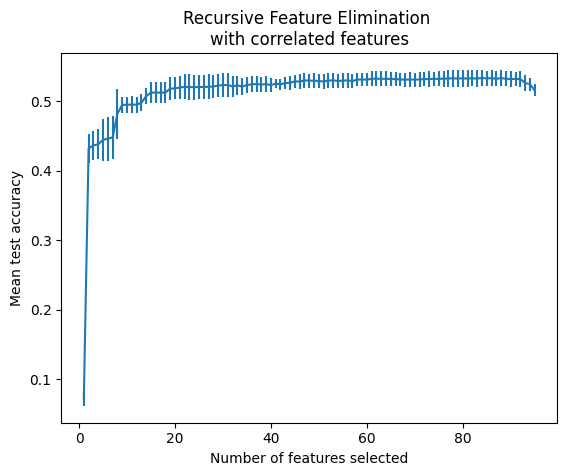

In [18]:
min_features_to_select = 1  # Minimum number of features to consider
clf = LogisticRegression(class_weight='balanced')
cv = StratifiedKFold(5)

rfecv_lr = RFECV(
    estimator=clf,
    step=1,
    cv=cv,
    scoring='f1',
    min_features_to_select=min_features_to_select,
    n_jobs=2,
)
rfecv_lr.fit(X_train_transformed_df, y_train)

print(f"Optimal number of features: {rfecv_lr.n_features_}")


# Plot number of features VS. cross-validation scores
# ---------------------------------------------------

import matplotlib.pyplot as plt

n_scores = len(rfecv_lr.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(min_features_to_select, n_scores + min_features_to_select),
    rfecv_lr.cv_results_["mean_test_score"],
    yerr=rfecv_lr.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

In [19]:
pd.set_option('display.max_rows', None)
pd.DataFrame(rfecv_lr.get_feature_names_out(),rfecv_lr.cv_results_["mean_test_score"][:84])

,0
0.072074,num__age
0.432363,num__limit_bal
0.436869,num__bill_amt3
0.438290,num__bill_amt4
0.444686,num__bill_amt5
0.446471,num__bill_amt6
0.448125,num__pay_amt1
0.482366,num__pay_amt2
0.495051,num__avg_bill_amt
0.495210,num__avg_leverage_ratio


#### Feature Selection

In [20]:
feature_importance = pd.DataFrame({'features': rfecv_lr.get_feature_names_out(), 'importance': rfecv_lr.estimator_.coef_[0]}) \
                            .sort_values(by = 'importance', ascending=False)
feature_importance = feature_importance[feature_importance['importance']>0]

In [21]:
X_train_fs1_df = X_train_transformed_df[feature_importance['features']]
x_test_fs1_df = x_test_transformed_df[feature_importance['features']]
report3 = evaluate_models(X_train_fs1_df, y_train, x_test_fs1_df, y_test, models)
report3

Baseline Classifier
Model performance for Training set
- Accuracy: 0.7788
- F1 score: 0.0000
- Precision: 0.0000
- Recall: 0.0000
- Roc Auc Score: 0.5000
Confusion Matrix: 
 [[18691     0]
 [ 5309     0]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.78      1.00      0.88     18691
           1       0.00      0.00      0.00      5309

    accuracy                           0.78     24000
   macro avg       0.39      0.50      0.44     24000
weighted avg       0.61      0.78      0.68     24000

----------------------------------
Model performance for Test set
- Accuracy: 0.7788
- F1 score: 0.0000
- Precision: 0.0000
- Recall: 0.0000
- Roc Auc Score: 0.5000
Confusion Matrix: 
 [[4673    0]
 [1327    0]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.78      1.00      0.88      4673
           1       0.00      0.00      0.00      1327

    accuracy                           0.7

Extra tree
Model performance for Training set
- Accuracy: 0.9938
- F1 score: 0.9859
- Precision: 0.9960
- Recall: 0.9761
- Roc Auc Score: 0.9875
Confusion Matrix: 
 [[18670    21]
 [  127  5182]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.99      1.00      1.00     18691
           1       1.00      0.98      0.99      5309

    accuracy                           0.99     24000
   macro avg       0.99      0.99      0.99     24000
weighted avg       0.99      0.99      0.99     24000

----------------------------------
Model performance for Test set
- Accuracy: 0.7977
- F1 score: 0.4482
- Precision: 0.5647
- Recall: 0.3715
- Roc Auc Score: 0.6451
Confusion Matrix: 
 [[4293  380]
 [ 834  493]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.84      0.92      0.88      4673
           1       0.56      0.37      0.45      1327

    accuracy                           0.80      60

,Model Name,Train Accuracy,Test Accuracy,Train_F1,Test_F1,Test_ROC_AUC_score,Train_ROC_AUC_score,Train_presicion,Test_precision,Train_recall,Test_recall,F2-Score
6,Gradient Boost,0.824708,0.824833,0.482852,0.482521,0.661729,0.661910,0.694975,0.696023,0.369938,0.369254,0.407518
9,XGBoost,0.864667,0.821000,0.605730,0.475073,0.658189,0.723368,0.851827,0.675939,0.469957,0.366240,0.403186
5,Random Forest,0.993750,0.815000,0.985771,0.473934,0.658115,0.988368,0.992929,0.638570,0.978715,0.376790,0.410442
1,Logistic Regression,0.814958,0.821500,0.423022,0.449357,0.645291,0.632994,0.681742,0.707120,0.306649,0.329314,0.368714
8,Extra tree,0.993833,0.797667,0.985921,0.448182,0.645098,0.987477,0.995964,0.564719,0.976078,0.371515,0.398803
2,SVM,0.822083,0.821500,0.451721,0.448223,0.644751,0.646401,0.709560,0.708469,0.331324,0.327807,0.367275
7,Adaboost,0.815958,0.820000,0.422992,0.434555,0.638392,0.633029,0.690111,0.711835,0.304954,0.312735,0.352232
4,Decision Tree,0.993833,0.730667,0.985921,0.406319,0.618273,0.987477,0.995964,0.396416,0.976078,0.416729,0.412502
3,Naive Bayes,0.788708,0.790167,0.189029,0.199619,0.549633,0.546217,0.626059,0.638211,0.111320,0.118312,0.141340
0,Baseline Classifier,0.778792,0.778833,0.000000,0.000000,0.500000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000


#### Data Sampling

In [22]:

# Resampling the minority class. The strategy can be changed as required.
smt = SMOTETomek(random_state=42,sampling_strategy='auto',n_jobs=-1)
# Fit the model to generate the data.
X_train_transformed_sampled, y_train_sampled = smt.fit_resample(X_train_fs1_df, y_train)
report4 = evaluate_models(X_train_transformed_sampled, y_train_sampled, x_test_fs1_df, y_test, models)
report4

Baseline Classifier
Model performance for Training set
- Accuracy: 0.5000
- F1 score: 0.0000
- Precision: 0.0000
- Recall: 0.0000
- Roc Auc Score: 0.5000
Confusion Matrix: 
 [[17714     0]
 [17714     0]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.50      1.00      0.67     17714
           1       0.00      0.00      0.00     17714

    accuracy                           0.50     35428
   macro avg       0.25      0.50      0.33     35428
weighted avg       0.25      0.50      0.33     35428

----------------------------------
Model performance for Test set
- Accuracy: 0.7788
- F1 score: 0.0000
- Precision: 0.0000
- Recall: 0.0000
- Roc Auc Score: 0.5000
Confusion Matrix: 
 [[4673    0]
 [1327    0]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.78      1.00      0.88      4673
           1       0.00      0.00      0.00      1327

    accuracy                           0.7

Extra tree
Model performance for Training set
- Accuracy: 0.9950
- F1 score: 0.9950
- Precision: 0.9953
- Recall: 0.9947
- Roc Auc Score: 0.9950
Confusion Matrix: 
 [[17630    84]
 [   94 17620]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     17714
           1       1.00      0.99      0.99     17714

    accuracy                           0.99     35428
   macro avg       0.99      0.99      0.99     35428
weighted avg       0.99      0.99      0.99     35428

----------------------------------
Model performance for Test set
- Accuracy: 0.7612
- F1 score: 0.4631
- Precision: 0.4605
- Recall: 0.4657
- Roc Auc Score: 0.6554
Confusion Matrix: 
 [[3949  724]
 [ 709  618]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.85      0.85      0.85      4673
           1       0.46      0.47      0.46      1327

    accuracy                           0.76      60

,Model Name,Train Accuracy,Test Accuracy,Train_F1,Test_F1,Test_ROC_AUC_score,Train_ROC_AUC_score,Train_presicion,Test_precision,Train_recall,Test_recall,F2-Score
6,Gradient Boost,0.767980,0.782000,0.747217,0.539761,0.708964,0.767980,0.820657,0.506271,0.685842,0.577995,0.562069
7,Adaboost,0.731117,0.765500,0.703332,0.523858,0.700259,0.731117,0.784385,0.475430,0.637462,0.583271,0.557958
1,Logistic Regression,0.700773,0.799667,0.635115,0.534830,0.699801,0.700773,0.813652,0.549722,0.520831,0.520723,0.526276
2,SVM,0.715536,0.779333,0.667481,0.522022,0.695381,0.715536,0.803160,0.501040,0.571017,0.544838,0.535476
9,XGBoost,0.869708,0.798167,0.861356,0.511497,0.683460,0.869708,0.920347,0.550347,0.809473,0.477769,0.490712
5,Random Forest,0.994947,0.763833,0.994952,0.481142,0.667624,0.994947,0.994083,0.467949,0.995823,0.495102,0.489422
8,Extra tree,0.994976,0.761167,0.994974,0.463095,0.655390,0.994976,0.995255,0.460507,0.994693,0.465712,0.464662
4,Decision Tree,0.994976,0.683667,0.994974,0.400505,0.609953,0.994976,0.995255,0.344753,0.994693,0.477769,0.443543
3,Naive Bayes,0.579316,0.800167,0.303747,0.293459,0.580874,0.579316,0.880553,0.672973,0.183527,0.187641,0.219267
0,Baseline Classifier,0.500000,0.778833,0.000000,0.000000,0.500000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000


In [23]:
report4[report4['Test_F1']>0.5]

,Model Name,Train Accuracy,Test Accuracy,Train_F1,Test_F1,Test_ROC_AUC_score,Train_ROC_AUC_score,Train_presicion,Test_precision,Train_recall,Test_recall,F2-Score
6,Gradient Boost,0.767980,0.782000,0.747217,0.539761,0.708964,0.767980,0.820657,0.506271,0.685842,0.577995,0.562069
7,Adaboost,0.731117,0.765500,0.703332,0.523858,0.700259,0.731117,0.784385,0.475430,0.637462,0.583271,0.557958
1,Logistic Regression,0.700773,0.799667,0.635115,0.534830,0.699801,0.700773,0.813652,0.549722,0.520831,0.520723,0.526276
2,SVM,0.715536,0.779333,0.667481,0.522022,0.695381,0.715536,0.803160,0.501040,0.571017,0.544838,0.535476
9,XGBoost,0.869708,0.798167,0.861356,0.511497,0.683460,0.869708,0.920347,0.550347,0.809473,0.477769,0.490712


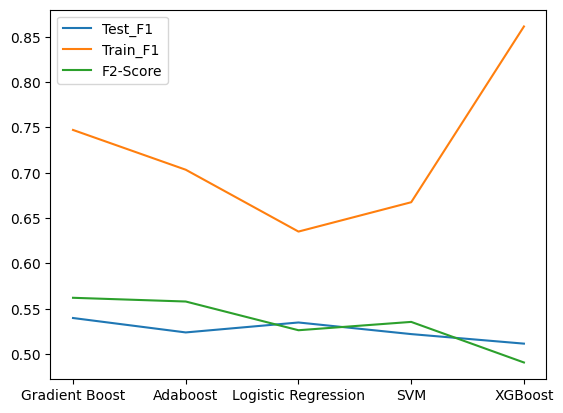

In [29]:
data = report4[report4['Test_F1']>0.5]
plt.plot('Model Name', 'Test_F1', data=data)
plt.plot('Model Name', 'Train_F1', data=data)
plt.plot('Model Name', 'F2-Score', data=data)
plt.legend()
plt.show()

#### Hyper parameter tuning

In [34]:

#logistic regression with hyperparameter tuning
lr = LogisticRegression()
params = {'penalty': ['l1', 'l2', 'elasticnet'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'max_iter':[100, 110, 120, 130, 140],
          'class_weight': ['balanced']}
skf= StratifiedKFold(n_splits=10)
lr_hyper = GridSearchCV(lr, param_grid=params, n_jobs=-1, cv=skf)
lr_hyper.fit(X_train_fs1_df, y_train)
y_pred = lr_hyper.predict(x_test_fs1_df)

In [35]:
display_confusion_matrix(y_test, y_pred, lr_hyper.classes_)

Confusion Matrix: 
 [[4115  558]
 [ 639  688]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.87      0.88      0.87      4673
           1       0.55      0.52      0.53      1327

    accuracy                           0.80      6000
   macro avg       0.71      0.70      0.70      6000
weighted avg       0.80      0.80      0.80      6000



In [37]:
lr_hyper.best_params_

{'C': 100, 'class_weight': 'balanced', 'max_iter': 100, 'penalty': 'l2'}

LogisticRegression()

####  Model interpretability using SHAP

(30000, 24)

#### Evaluate models based on F1-Score and AUC ROC score

In [ ]:
'''
def plot_roc_auc_curve(y_true, y_pred, model, x_test, name):
    #plot Roc-auc curve
    model_roc_auc = roc_auc_score(y_true, y_pred)
    fpr, tpr, threshold = roc_curve(y_true, model.predict_proba(x_test)[:,1])
    plt.figure(figsize=(10, 5))
    #following code adapted from roc_auc_curve scikit-learn documentation
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='{0} ROC curve (area = {1:.2f})' .format(name, model_roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    

In [ ]:
#lr = LogisticRegression(class_weight='balanced',)
#lr.fit(X_train_transformed, y_train)
#y_pred = lr.predict(x_test_transformed)

In [ ]:
#svm = SVC(class_weight='balanced', probability=True)
#svm.fit(X_train_transformed, y_train)
#y_pred_svm = svm.predict(x_test_transformed)

In [ ]:
'''
model_roc_auc_lr = roc_auc_score(y_test, y_pred)
fpr_lr, tpr_lr, threshold_lr = roc_curve(y_test, lr.predict_proba(x_test_transformed)[:,1])
model_roc_auc_svm = roc_auc_score(y_test, y_pred_svm)
fpr_svm, tpr_svm, threshold_svm = roc_curve(y_test, svm.predict_proba(x_test_transformed)[:,1])
plt.figure(figsize=(10, 5))
#following code adapted from roc_auc_curve scikit-learn documentation
lw = 2
plt.plot(fpr_lr, tpr_lr, color='darkorange',
           lw=lw, label='{0} ROC curve (area = {1:.2f})' .format("Logistic Regression", model_roc_auc_lr))
plt.plot(fpr_svm, tpr_svm, color='lightblue',
           lw=lw, label='{0} ROC curve (area = {1:.2f})' .format("SVM", model_roc_auc_svm))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

#plot_roc_auc_curve(y_test, y_pred, lr, x_test_transformed, name="Logistic Regression")

In [ ]:
'''
#logistic regression with hyperparameter tuning
lr = LogisticRegression()
params = {'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'max_iter':[100, 110, 120, 130, 140],
          'class_weight': ['balanced']}
skf= StratifiedKFold(n_splits=10)
lr_hyper = GridSearchCV(lr, param_grid=params, n_jobs=-1, cv=skf)
lr_hyper.fit(X_train_transformed, y_train)
y_pred = lr_hyper.predict(x_test_transformed)

In [ ]:
#display_confusion_matrix(y_test, y_pred, lr_hyper.classes_)

In [ ]:
#print(fbeta_score(y_test, y_pred, beta=2))

In [ ]:
#lr_hyper.best_params_